# Case study: Row-Column Addressed Matrix Probe

## Row-Column Addressed probes

Row-Column Addressed (RCA) probe is a low-cost and portable alternative for fully-populated matrix-array probes in 3D volume reconstruction. 

In 3D ultrasound imaging matrix-array probes are currently the most popular choice. These probes have $n \times n$ elements arranged in a plane along two axis (see images below). It's a natural extension of linear-array probes whose elements are distributed only along a single axis.

One of the problem in handling matrix-array probes is a large number of ultrasound system channels that are needed to control all of the prob'es elements. In the case of matrix array probe this is equal to $n^2$, so it increases squarely with the number of elements along a single axis. For example, the currently popular $32 \times 32$ probes requires an ultrasound system with 1024 channels. Compare it to a linear-array probe, which has 192 elements distributed along axis and requires a system with only 192 channels. 

Various attempts have been made to implement 3D volume reconstruciton using a system with a limited number of components. Te RCA probes are gaining more and more popularity mostly due to large number of elements (and therefore a larger aperture) that can be handled by small number of system channels and ease of implementation of synthetic aperture methods. There are also some challenges and limitations, in particular [Jensen2022]:
- mostly it is possible to image a rectangular area below the probe only,
- the long probe elements needs to be considered on the beamforming stage (cylindrical wave: the emitted field can be considered as plane wave along the first axis and rectangular along the second), 
- some new artifacts like edge waves must be considered in the imaging procedure, which means we may need to implement some additional techniques like roll-off apodization.

In this notebook we present the possiblity of implementing plane wave imaging on RCA probes data. Here we focus on CUDA beamformer implementation details.

This notebook on the work presented in [Flesch2017] and [Jensen2022].

### Coordinate system

In this notebook we assume the following coordinate system:
- the origin of the system $(0,0,0)$ is located in the center of the probe, 
- OX axis is along probe's azimuth,
- OY is along probe's elevation,
- OZ - depth (towards direction of imaging).

See the below image for more details.

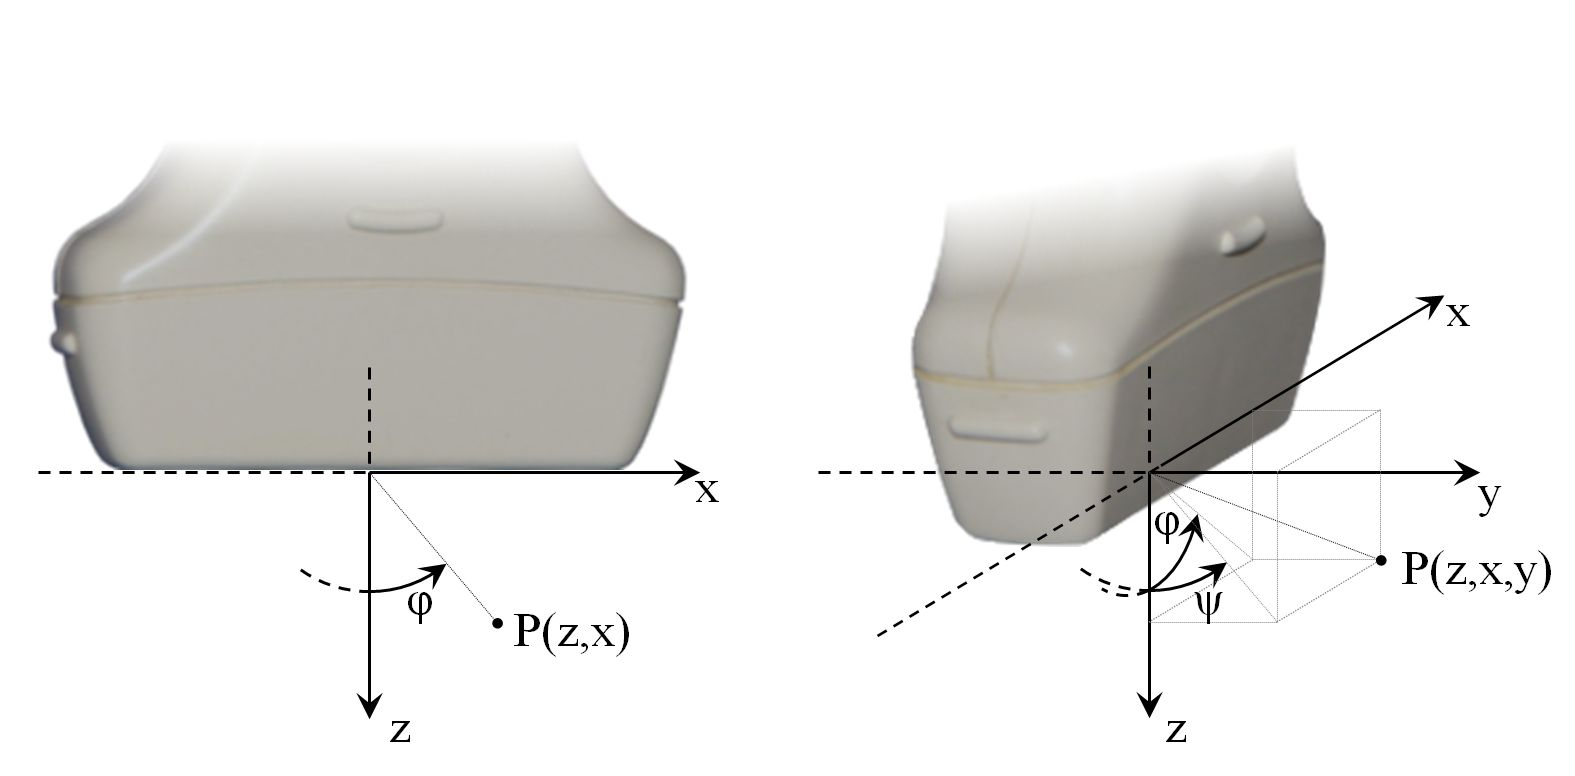

### Rows and columns in RCA probes

The figure below shows the idea of the RCA probe construction:
1. _(the image 1st on the left)_: Here we consider a probe with $6 \times 6$ elements. These elements are evenly distributed along both of the axis. If we wanted to control all elements of the probe, we need a system with 36 channels.
2. _(the 2nd and 3rd image)_: Instead of controlling all the elements of the probe, in the case of RCA probe we want to control a group of elements that are spread across along OX or OY axis. In other words, we would like to control 6 long elements along OX axis and 6 long elements along OY axis. This way, in particular, we are able to control the signal beamforming along the OX axis (e.g. on transmission) and and OY axis (e.g. on reception), which gives us some degrees of freedom for 3D volume reconstruction. What is more, we only need $6+6$ channels to control the probe.

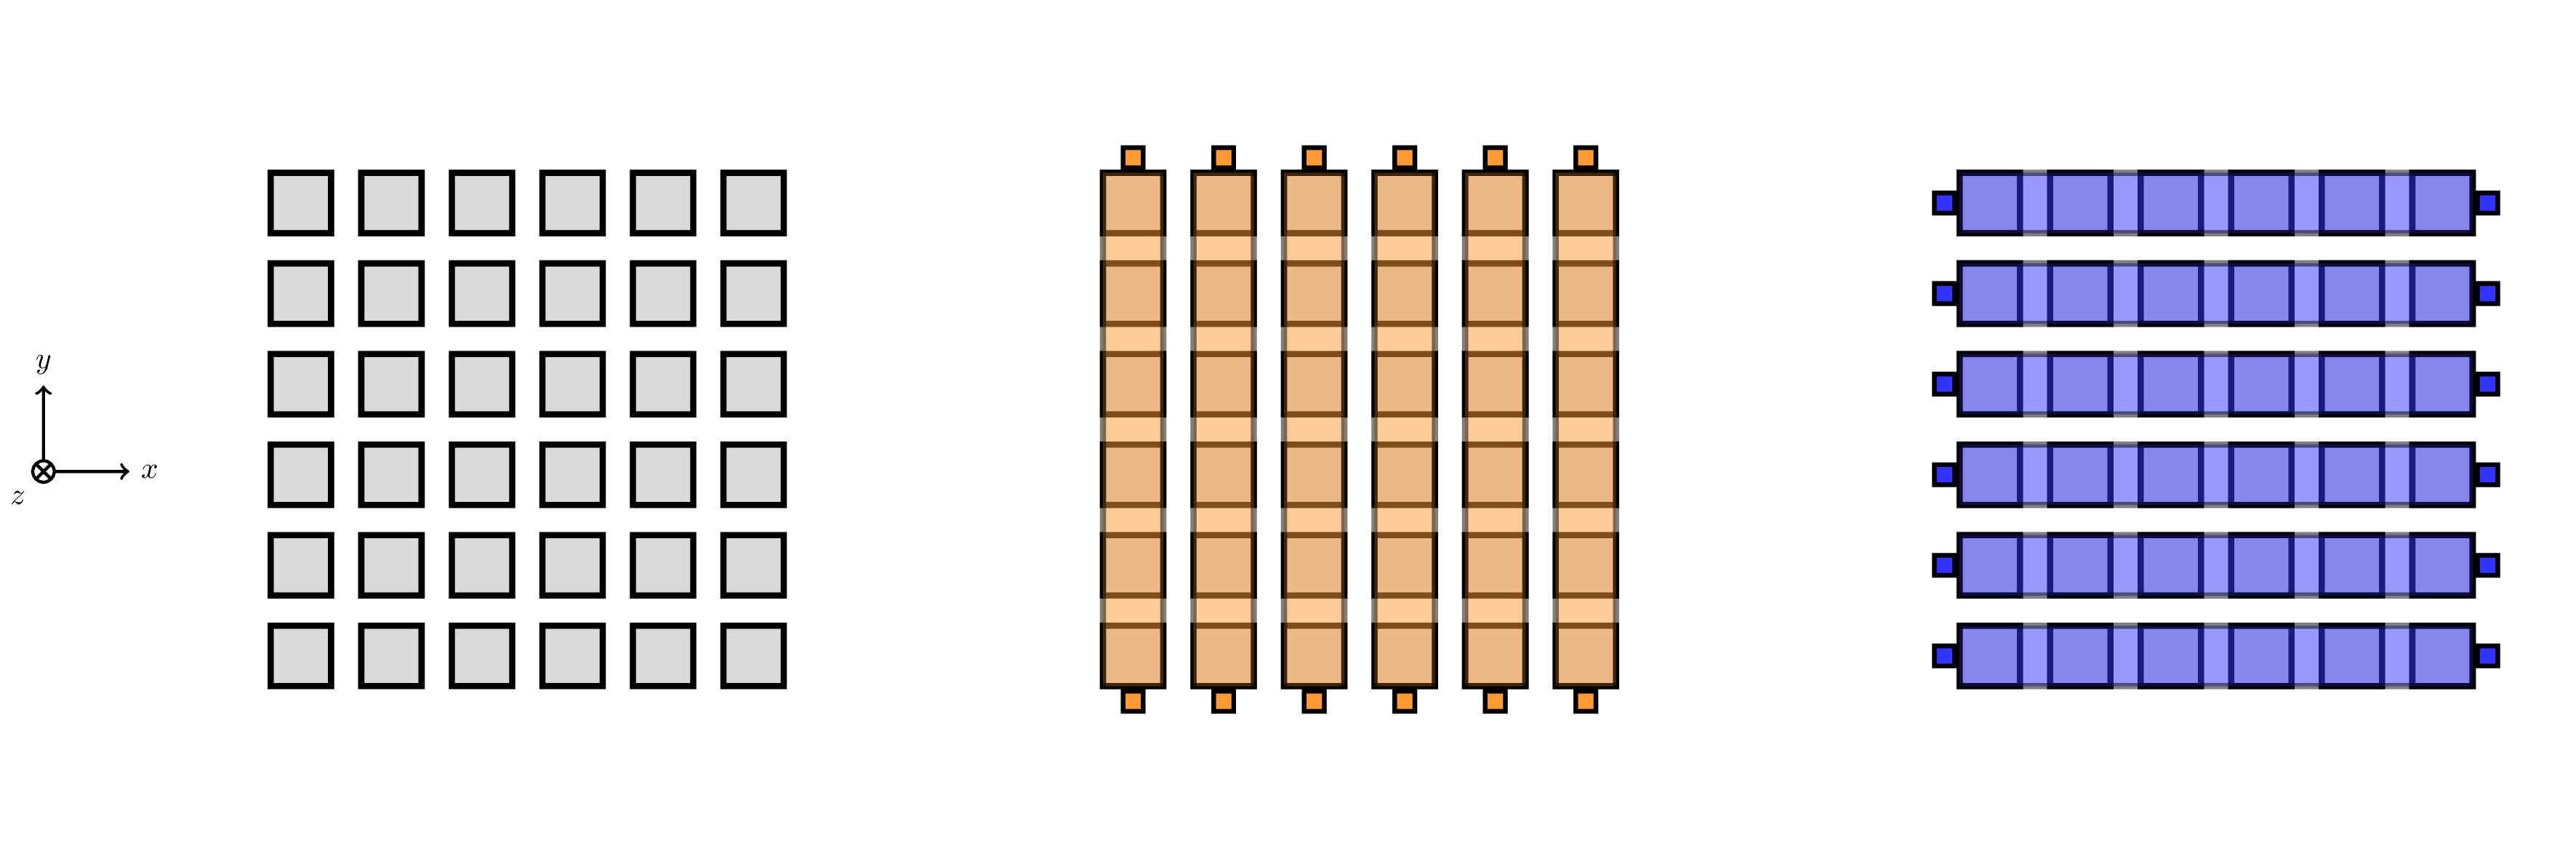

## Plane Wave Imaging with RCA

In the case of imaging with the RCA head, we must be able to control elements distributed along the OX/OY axis and receive the signal with orthogonal elements (OY/OX), otherwise, we will have a situation similar to a linear-array probe (but with the elements are much longer). The image below shows the idea: let's assume, that we transmit signal using elements distributed along OX axis (orange), and receive data using orthogonal elements (OY axis, blue).

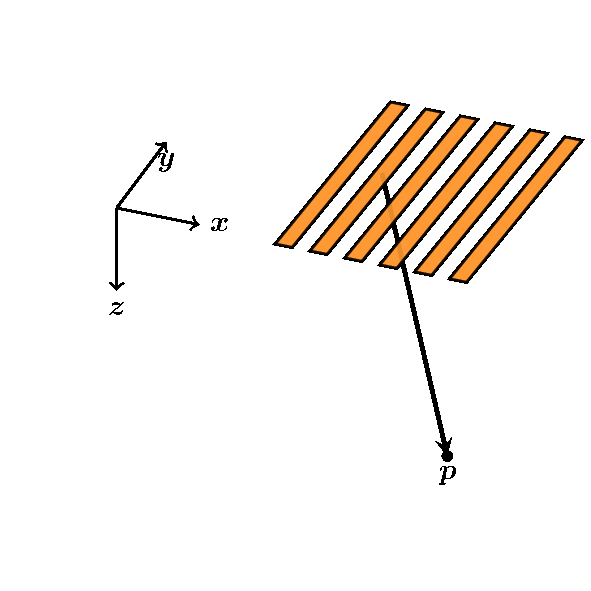

In the case of plane wave transmission the emitted fields should have a rectangular shape, tilted along one of the axis according to the steering angle $\varphi$ (see image below, orange dotted lines). As usually, on the beamforming stage we take a ray-tracing approach, that is, we need first to determine how much time it takes to propage signal from probe to the target point, then back to the receive channels. After determining the transmit and delay, we run the usual delay and sum algorithm in order to the information about the signal in each imaging grid point.

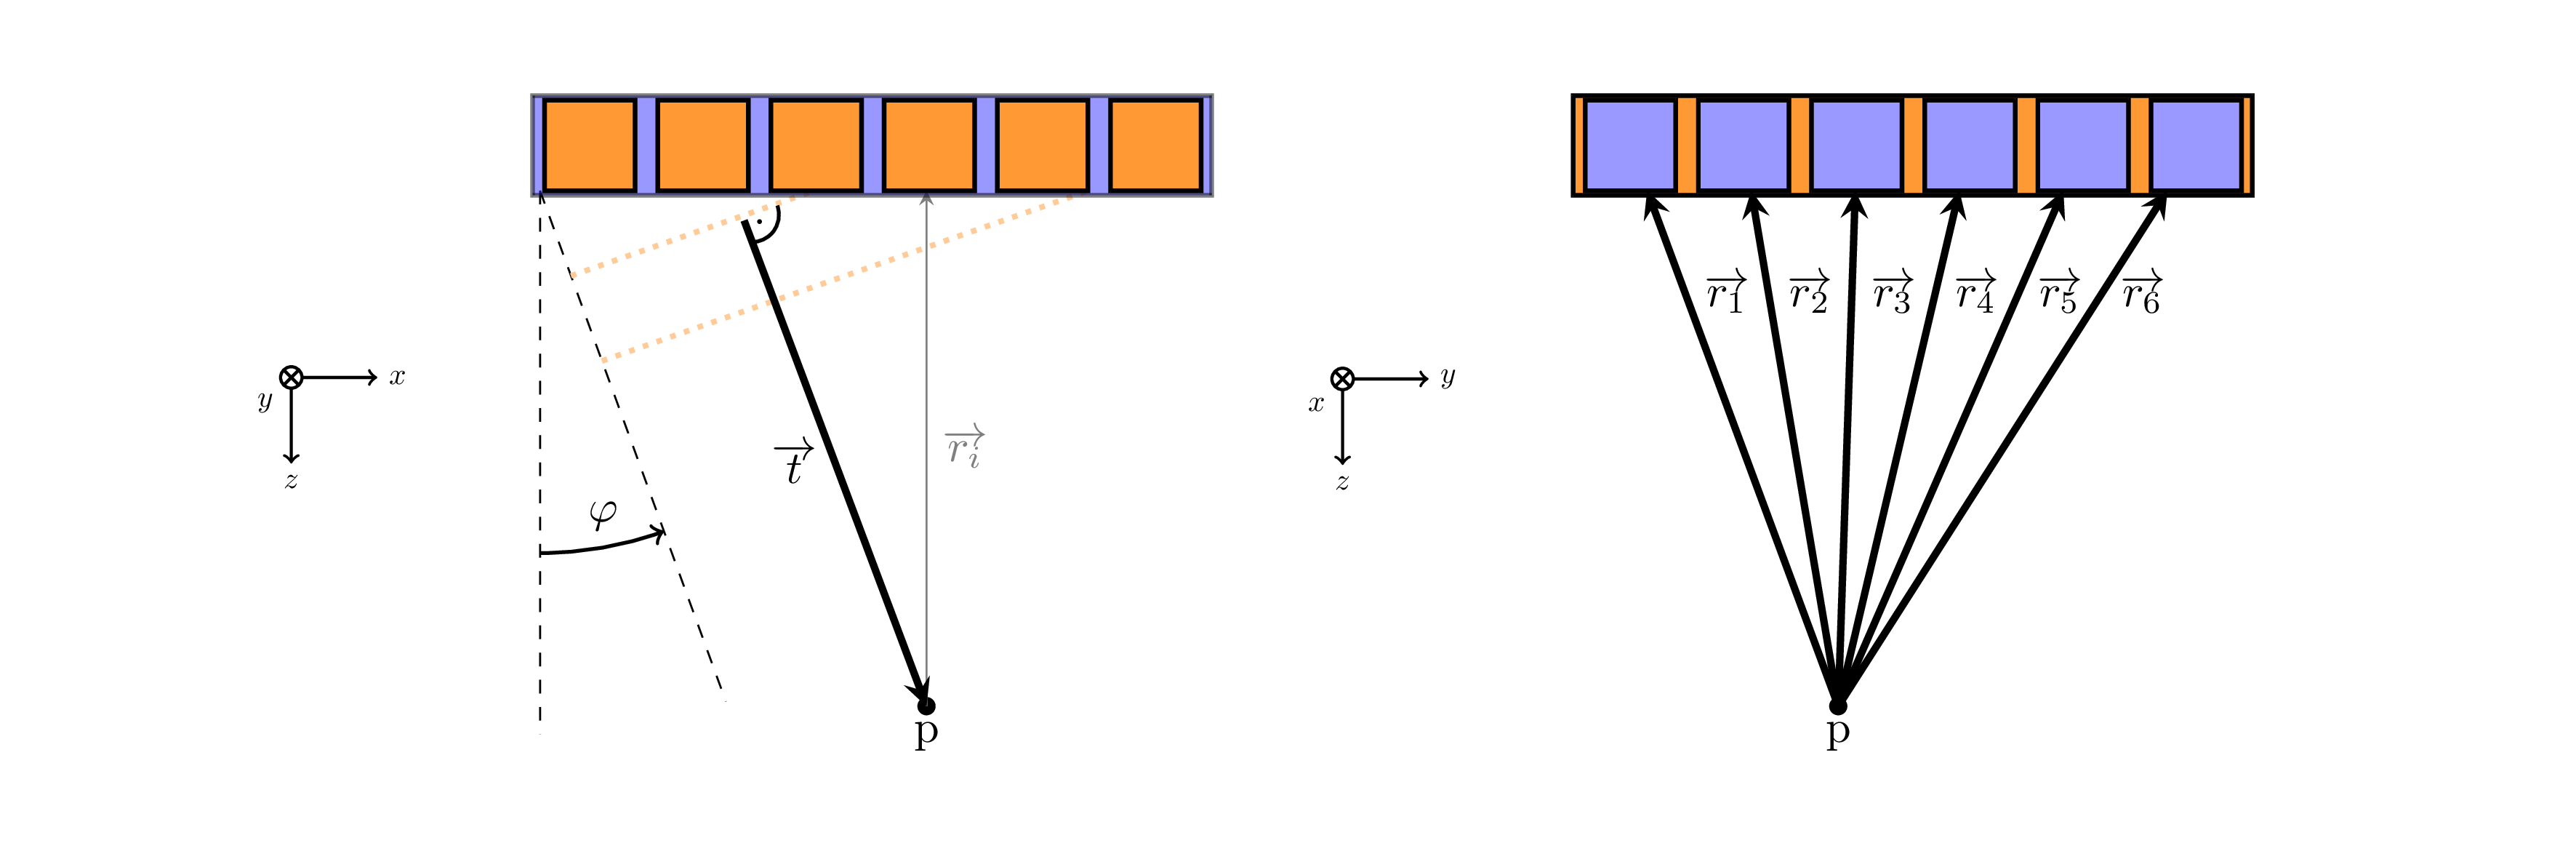

The transmit delay can be computed following in the following way [Flesch2017]:

$\tau(x, y, z, \varphi, r_i) = \frac{\| \overrightarrow{t} \| + \|\overrightarrow{r_i}\|}{c}$

$\|\overrightarrow{t}\| = z\cos(\varphi) + x \sin(\varphi)$

$\|\overrightarrow{r_i}\| = \sqrt{z^2 + (y-r_i)^2}$ 

where:
- $\tau$: receive beamforming delay $[s]$,
- $p = (x, z, y)$ - a target point,
- $\overrightarrow{t}$ - a vector from the transimssion point to the target point $p$,
- $\overrightarrow{r_i}$ - a vector from the target point $p$ to the receive element $r_i$,
- $\varphi$ - steering angle $[rad]$,
- $c$ - speed of sound $[m/s]$. 

Basing on the transmission and receive delays, we can make a couple of observations:
- Using RCA probe we are only able to steer the transmission using angles $(\varphi, \psi=0)$ or $(\varphi=0, \psi)$,
- In the receive beamforming,  $\|\overrightarrow{t}\|$ **does not depend on the** $y$ **value, and** $\|\overrightarrow{r_i}\|$ **does not depend on the** $x$ **value**. That means, in particular, that we need to compute transmit delays only for each $(x, z)$ pair, and use it for all voxels along OY axis. Thus, we are able to reduce calculation along one of the dimensions.

Utility functions

In [1]:
def pretty_print_h5_group(group):
    """
    Pretty print the content of input h5py Group.
    """
    def print_values(name, node):
        if isinstance(node, h5py.Dataset):
            if node.shape == (1, ):
                # print scalar value
                print(f"{name}: {float(node[0]):.4f}")
            else:
                print(f"{name}: {node.shape}, {node.dtype}")
        else:
            print(f"Group: {name}")
    group.visititems(print_values)    

## Volume reconstruction

Let's do all the necessary imports first.

In [2]:
import numpy as np
import scipy.io
import scipy.signal
import scipy.ndimage
import matplotlib.pyplot as plt
import cupy as cp
import h5py
from itkwidgets import view
import pathlib

### Data sets

We are using a synthetic data...

Data was generated in k-wave...

Note: we are using SI base units (m/s, m, s...).

#### Get data

! wget ...

In [3]:
f = h5py.File("cyst.h5", "r")

Below we describe groups and arrays available int the input file.

#### Medium

In [4]:
medium = f["medium"]
pretty_print_h5_group(medium)

density_array: (108, 108, 216), float64
dx: 0.0003
speed_of_sound: 1540.0000
speed_of_sound_array: (108, 108, 216), float64


Where:
- `speed_of_sound`: assumed speed of sound in the medium,
- `dx`: a distance between two grid points in the density_array and speed_of_sound_array,
- `density_array`: a 3D map of density in the medium,
- `speed_of_sound_array`: a 3D map of speed of sound in the medium.

We use the `dx`, `density_array` and `speed_of_sound` parameters only to visualize the medium through which ultrasound beam was propagated.

#### Device

In [5]:
device = f["device"]
pretty_print_h5_group(device)

n_elements_xy: 64.0000
n_elements_yx: 64.0000
pitch: 0.0003
probe_mask: (108, 108, 216), uint8
sampling_frequency: 21388692.0000


#### TX/RX Sequence

In [6]:
tx_rx_sequence = f["tx_rx_sequence"]
pretty_print_h5_group(tx_rx_sequence)

angles: (34,), float64
init_delay: (1, 1), float32
transmit_frequency: 3000000.0000


#### Setup

In [7]:
def view_medium_and_probe_3d(medium, device, probe_c):
    array = medium["speed_of_sound_array"][:]
    probe = device["probe_mask"][:]
    array[probe == 1] = probe_c
    return view(array, axes=True, blend_mode="Maximum", units="grid points", annotations=True, rotate=True)

def view_medium_and_probe_2d(medium, device, probe_c, figsize=(10, 10)):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    array = medium["speed_of_sound_array"][:]
    probe = device["probe_mask"][:]
    dx = medium["dx"][:].item()
    array[probe == 1] = probe_c
    fig, (ax_oxz, ax_oyz) = plt.subplots(1, 2)
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)
    fig.set_size_inches(figsize)
    nx, ny, nz = array.shape
    extent_oxz = np.array([-nx//2, nx//2, nz, 0])*dx*1e3  # (mm)
    extent_oyz = np.array([-ny//2, ny//2, nz, 0])*dx*1e3  # (mm)
    img = ax_oxz.imshow(array[:, ny//2, :].T, extent=extent_oxz, cmap="plasma")
    ax_oxz.set_title("$y=0$")
    ax_oxz.set_xlabel("OX (mm)")
    ax_oxz.set_ylabel("OZ (mm)")
    cbar = fig.colorbar(img, ax=ax_oxz)
    cbar.ax.set_ylabel("Speed of sound (m/s)")
    img = ax_oyz.imshow(array[nx//2, :, :].T, extent=extent_oyz, cmap="plasma")
    ax_oyz.set_xlabel("OY (mm)")
    ax_oyz.set_ylabel("OZ (mm)")
    ax_oyz.set_title("$x=0$")
    cbar = fig.colorbar(img, ax=ax_oyz)
    cbar.ax.set_ylabel("Speed of sound (m/s)")

In [8]:
view_medium_and_probe_3d(medium, device, probe_c=1600)

<IPython.core.display.Javascript object>

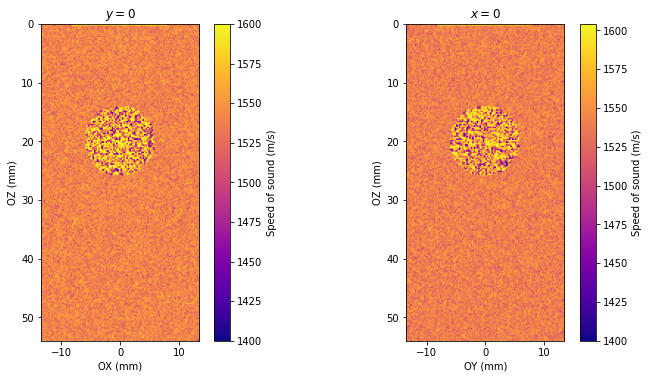

In [9]:
view_medium_and_probe_2d(medium, device, probe_c=1600, figsize=(10, 5))
plt.savefig("cyst_medium.png", bbox_inches="tight")
plt.show()

### Beamformer: Lookup Table (LUT) approach

- In this section we present a Lookup Table approach to implement input data beamformer
- We are preparing before staring beamforming
- Note: For plane wave imaging the arrays are only 3D, not 4D as it could be for 

####  Implementation details

In [10]:
def prepare_beamformer(output_grid, device, medium, tx_rx_sequence):
    # Initial assignments.
    x_grid, y_grid, z_grid = output_grid
    n_elements = device["n_elements_xy"][0] 
    # Note: we are assumming a probe with square (n+n) aperture.
    assert n_elements == device["n_elements_yx"][0]
    pitch = device["pitch"][0]
    angles = tx_rx_sequence["angles"][:]
    c = medium["speed_of_sound"][0]
    init_delay = tx_rx_sequence["init_delay"][0]
    fs = device["sampling_frequency"][0]
    fc = tx_rx_sequence["transmit_frequency"][0]
    
    # Compute position of the each probe element.
    ri = cp.arange(n_elements)-n_elements//2+0.5
    ri = ri*pitch
    
    # Restructure 
    x = cp.asarray(x_grid).reshape(1, -1, 1)      # (1,   nx, 1)
    y = cp.asarray(y_grid).reshape(1, -1, 1)      # (1,   ny, 1)
    z = cp.asarray(z_grid).reshape(1, 1, -1)      # (1,   1,  nz)
    gamma = cp.asarray(angles).reshape(-1, 1, 1)  # (ntx, 1,  1)
    ri = cp.asarray(ri).reshape(-1, 1, 1)         # (nrx, 1,  1)

    # TX delays
    tx_distance = z*np.cos(gamma) + x*cp.sin(gamma)  # [m]
    tx_delays = tx_distance/c  # [s]

    # RX delays
    rx_distance = cp.sqrt(z**2 + (y-ri)**2)
    rx_delays = rx_distance/c
    
    # "TX apodization"
    d1 = -n_elements/2 * pitch
    d2 = n_elements/2 * pitch
    tx_apodization_left = z*cp.sin(gamma) + (d1-x)*cp.cos(gamma) <= 0
    tx_apodization_right = z*cp.sin(gamma) + (d2-x)*cp.cos(gamma) >= 0
    tx_apodization = np.logical_and(tx_apodization_left, tx_apodization_right)
    tx_apodization = tx_apodization.astype(np.uint8)

    # RX apodization
    max_rx_tang = 0.5
    rx_sigma = 1/2
    rx_tang = cp.abs((ri-y)/z)
    rx_apodization = cp.exp(-(rx_tang/max_rx_tang)**2 / (2*rx_sigma))
    rx_apodization[rx_tang > max_rx_tang] = 0.0

    return {
        "tx_delays": tx_delays,
        "rx_delays": rx_delays,
        "tx_apodization": tx_apodization,
        "rx_apodization": rx_apodization,
        "init_delay": init_delay,
        "fs": fs,
        "fc": fc
    }

A bit more details about each part of the below function.

**TX delays**

- Transmit delays are computed according to the previously defined formulas, please check. 
- as you can note, tx delays zależą wyłącznie od tx, z oraz x
- przykład z rysunek opóźnień odbiorczych

**RX delays**

- Transmit delays are computed according to the previously defined formulas, please check. 
- as you can note, tx delays zależą wyłącznie od tx, z oraz x
- przykład z rysunkiem opóźnień odbiorczych

**TX apodization**

- jaki jest jej cel: żeby nie obrazować obszarów, do których fala ultradźwiękowa nie dociera
- w przypadku fali płaskiej: mówiąc najprościej chcemy sprawdzić, czy punkt (x, y, z) znajduje się po lewej (obszar poza insonifikacją), czy po prawej (obszar w insonifikacji) stronie wektora. Analogicznie, chcemy sprawdzic czy punkt znajduje się po lewej czy po prawej wektora ze skrajnej prawej strony apertury
- rozważmy przypadek z lewej: to co robimy, to:
    - przenieśmy początek układu współrzędnych do lewej skrajnej strony apertury
    - w tym momencie 
    - obróćmy wektor (x, z) o pi/2 -> (-z, x)
    - obliczmy iloczyn skalarny pomiędzy obróconym (x, z), a wektorem jednostkowym wyznaczajacym kierunek kąta gamma (oznaczmy go wektor{gamma})
    - jezeli iloczyn skalarny jest mniejszy od zera (t.j. (-z, x) jest obrocony wzgledem gamma o ... etc.)
- przykładowy rysunek (na podstawie wyników)


**RX apodization**
- ograniczenie sygnału do określonej kierunkowości elementów
- ograniczamy rekonstruowaną siatkę dla każdego elementu odbiorczego do obszaru, gdzie element widzi pod pewnym kątem

In [11]:
def delay_and_sum_lut(input_array, tx_apodization, rx_apodization,
             tx_delays, rx_delays, init_delay, fs, fc):
    # Initialization
    # Compile beamformer source code.
    kernel_source = pathlib.Path("1_delayAndSumLUT.cc").read_text()
    kernel_module = cp.RawModule(code=kernel_source)
    kernel_module.compile()
    kernel = kernel_module.get_function("delayAndSumLUT")
    n_tx, n_rx, n_samples = input_array.shape
    output_array = cp.zeros((n_tx, len(y_grid), len(x_grid), len(z_grid)),
                            dtype=cp.float32)
    input_array = cp.asarray(input_array).astype(cp.float32)
    n_tx, n_y_pix, n_x_pix, n_z_pix = output_array.shape
    params = (
        output_array,
        input_array,
        tx_apodization.astype(cp.uint8),
        rx_apodization.astype(cp.float32),
        tx_delays.astype(cp.float32),
        rx_delays.astype(cp.float32),
        np.float32(init_delay),
        n_tx, n_samples, n_rx,
        n_y_pix, n_x_pix, n_z_pix,
        np.float32(fs), np.float32(fc)
    )
    x_block_size = min(n_x_pix, 8)
    y_block_size = min(n_y_pix, 8)
    z_block_size = min(n_z_pix, 8)
    block_size = (
        z_block_size,
        x_block_size,
        y_block_size
    )
    grid_size = (
        (n_z_pix-1)//z_block_size+1,
        (n_x_pix-1)//x_block_size+1,
        (n_y_pix-1)//y_block_size+1
    )
    kernel(
        grid_size,
        block_size,
        params
    )
    return output_array.get()

In [73]:
def postprocess(data_xz, data_yz, tx_rx_sequence, output_grid, tgc_alpha_coeff=0, tgc_alpha_power=1, dynamic_range=(-20, 0)):
    data_yz = data_yz.transpose((0, 2, 1, 3))
    # Compound.
    hri = (np.mean(data_xz, axis=0)+np.mean(data_yz, axis=0))/2
    # TCG
    if tgc_alpha_coeff != 0:
        _, _, z_grid = output_grid
        z_grid = z_grid.get()
        fc = tx_rx_sequence["transmit_frequency"][0]
        gain = tgc_alpha_coeff*fc*1e-6*tgc_alpha_power
        gain = gain/8.686*1e2
        curve = np.exp(gain*2*z_grid).reshape(1, 1, -1)
        hri = hri*curve
    # Envelope.
    envelope = np.abs(scipy.signal.hilbert(hri))
    envelope_max = np.max(envelope)
    # B-mode.
    bmode = 20*np.log10(envelope/envelope_max)
    # Adjust dynamic range.
    vmin, vmax = dynamic_range
    bmode = np.clip(bmode, a_min=vmin, a_max=vmax)
    bmode = np.transpose(bmode, (2, 0, 1))
    return bmode

#### Testing

In [79]:
def view_volume_3d(volume):
    volume = np.flip(volume, axis=0)
    return view(volume, axes=True, blend_mode="Maximum", units="grid points", annotations=True, rotate=True)

def view_volume_2d(volume, x_grid, y_grid, z_grid, figsize=(10, 10)):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, (ax_oxz, ax_oyz) = plt.subplots(1, 2)
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)
    fig.set_size_inches(figsize)
    nz, nx, ny = volume.shape
    extent_oxz = np.array([np.min(x_grid), np.max(x_grid), np.max(z_grid), np.min(z_grid)])*1e3  # (mm)
    extent_oyz = np.array([np.min(y_grid), np.max(y_grid), np.max(z_grid), np.min(z_grid)])*1e3  # (mm)
    img = ax_oxz.imshow(volume[:, :, ny//2], extent=extent_oxz, cmap="gray")
    ax_oxz.set_title("$y=0$")
    ax_oxz.set_xlabel("OX (mm)")
    ax_oxz.set_ylabel("OZ (mm)")
    cbar = fig.colorbar(img, ax=ax_oxz)
    cbar.ax.set_ylabel("Amplitude (dB)")
    img = ax_oyz.imshow(volume[:, nx//2, :], extent=extent_oyz, cmap="gray")
    ax_oyz.set_xlabel("OY (mm)")
    ax_oyz.set_ylabel("OZ (mm)")
    ax_oyz.set_title("$x=0$")
    cbar = fig.colorbar(img, ax=ax_oyz)
    cbar.ax.set_ylabel("Amplitude (dB)")

**Single point**

In [14]:
f = h5py.File("ball.h5", "r")

x_grid = cp.arange(-4, 4, 0.1)*1e-3  # [m]
y_grid = cp.arange(-4, 4, 0.1)*1e-3  # [m]
z_grid = cp.arange(16, 24, 0.1)*1e-3  # [m]

beamformer_cfg = prepare_beamformer(
    output_grid=(x_grid, y_grid, z_grid),
    medium=f["medium"],
    device=f["device"],
    tx_rx_sequence=f["tx_rx_sequence"]
)
single_point_xy = delay_and_sum_lut(input_array=f["rf_xy"][:], **beamformer_cfg)
single_point_yx = delay_and_sum_lut(input_array=f["rf_yx"][:], **beamformer_cfg)
single_point = postprocess(single_point_xy, single_point_yx, dynamic_range=(-20, 0))

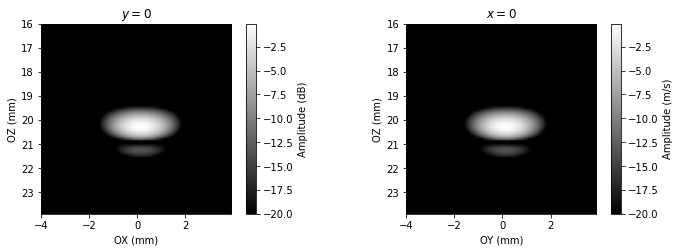

In [15]:
view_volume_2d(single_point, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 3))

In [16]:
view_volume_3d(single_point)

<IPython.core.display.Javascript object>

**Wire phantom**

In [81]:
f = h5py.File("multi_wire.h5", "r")

x_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
z_grid = cp.arange(5, 50, 0.1)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=f["medium"],
    device=f["device"],
    tx_rx_sequence=f["tx_rx_sequence"]
)
wires_xy = delay_and_sum_lut(input_array=f["rf_xy"][:], **beamformer_cfg)
wires_yx = delay_and_sum_lut(input_array=f["rf_yx"][:], **beamformer_cfg)

wires = postprocess(wires_xy, wires_yx, 
                     tx_rx_sequence=f["tx_rx_sequence"], 
                     output_grid=output_grid, 
                     tgc_alpha_coeff=0.7, tgc_alpha_power=1.5, 
                     dynamic_range=(-20, 0))

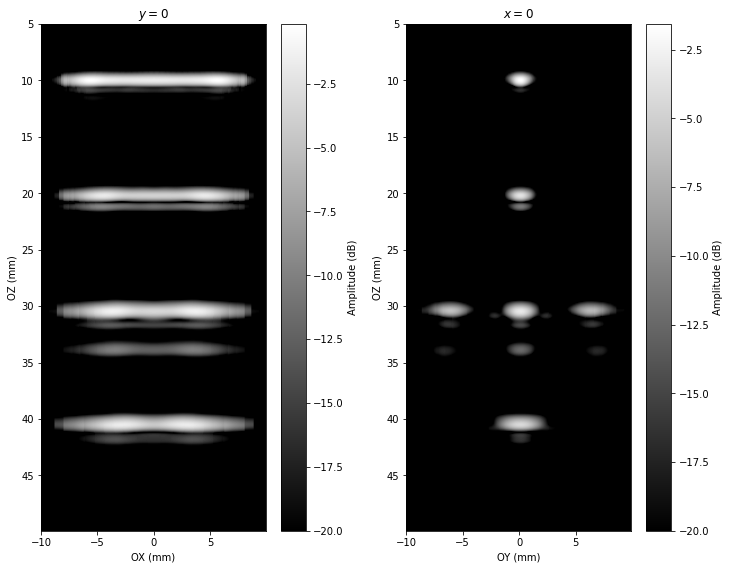

In [82]:
view_volume_2d(wires, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 8))


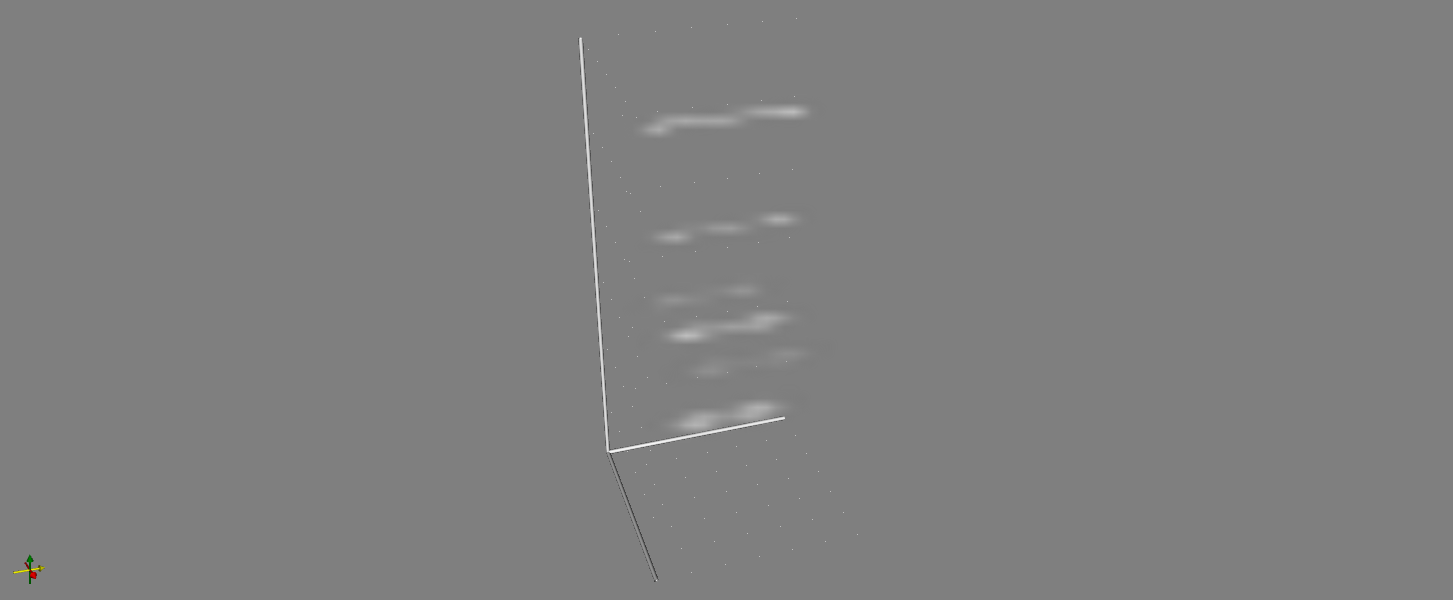
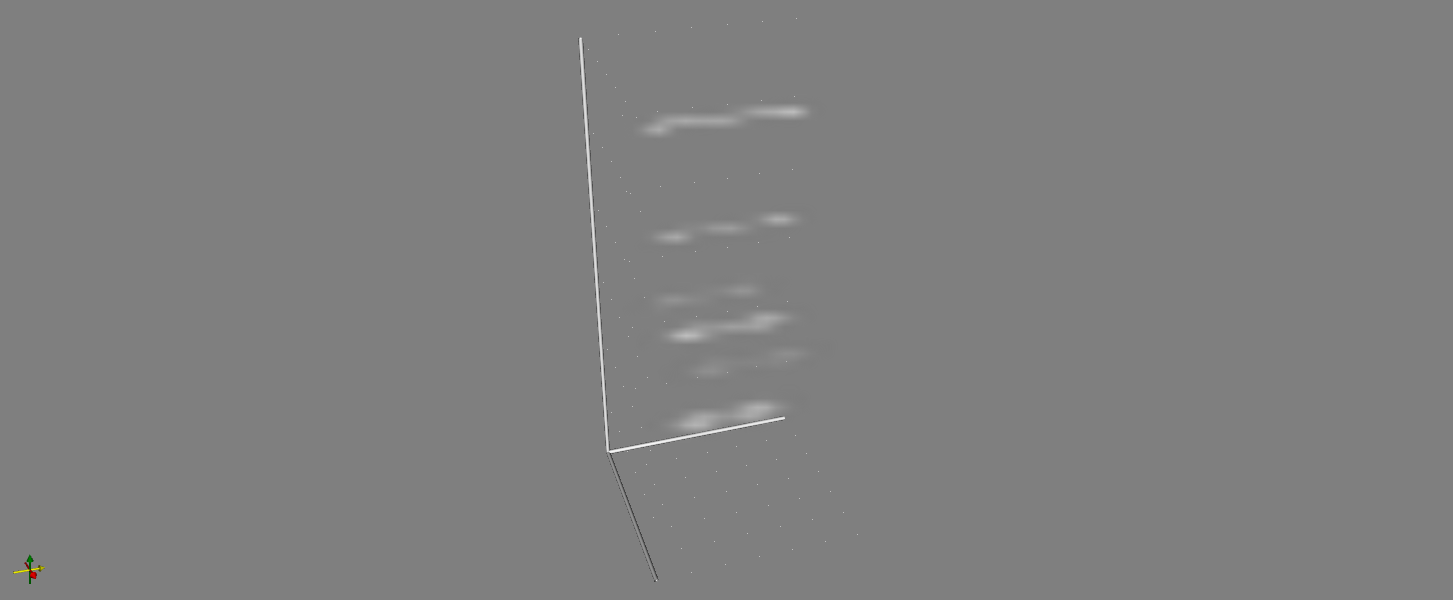

<IPython.core.display.Javascript object>

In [83]:
view_volume_3d(wires)

**Cyst**

In [87]:
f = h5py.File("cyst.h5", "r")

x_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
z_grid = cp.arange(5, 35, 0.1)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=(x_grid, y_grid, z_grid),
    medium=f["medium"],
    device=f["device"],
    tx_rx_sequence=f["tx_rx_sequence"]
)
cyst_xy = delay_and_sum_lut(input_array=f["rf_xy"][:], **beamformer_cfg)
cyst_yx = delay_and_sum_lut(input_array=f["rf_yx"][:], **beamformer_cfg)
cyst = postprocess(cyst_xy, cyst_yx, 
                   tx_rx_sequence=f["tx_rx_sequence"], 
                   output_grid=output_grid, 
                   tgc_alpha_coeff=0.7, tgc_alpha_power=1.5, 
                   dynamic_range=(-30, 0))

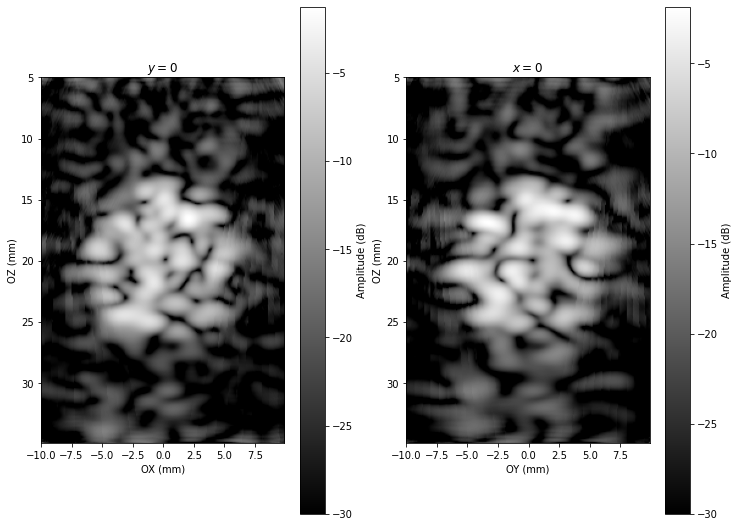

In [88]:
view_volume_2d(cyst, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 8))


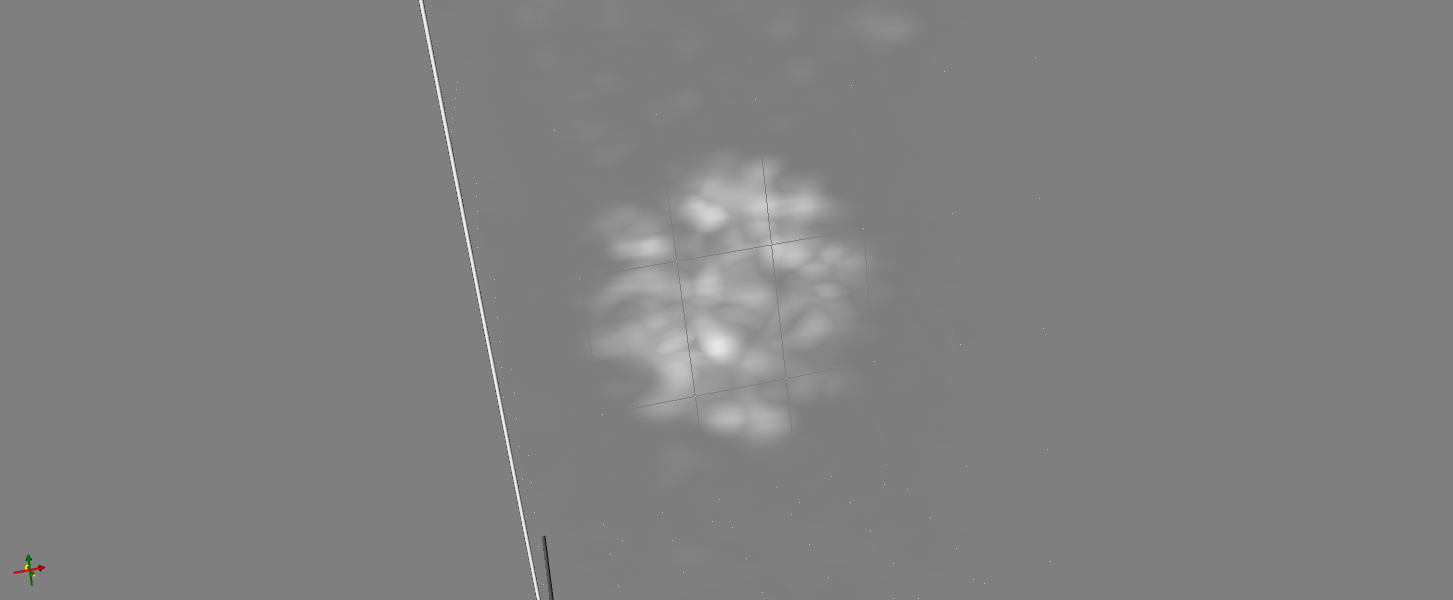
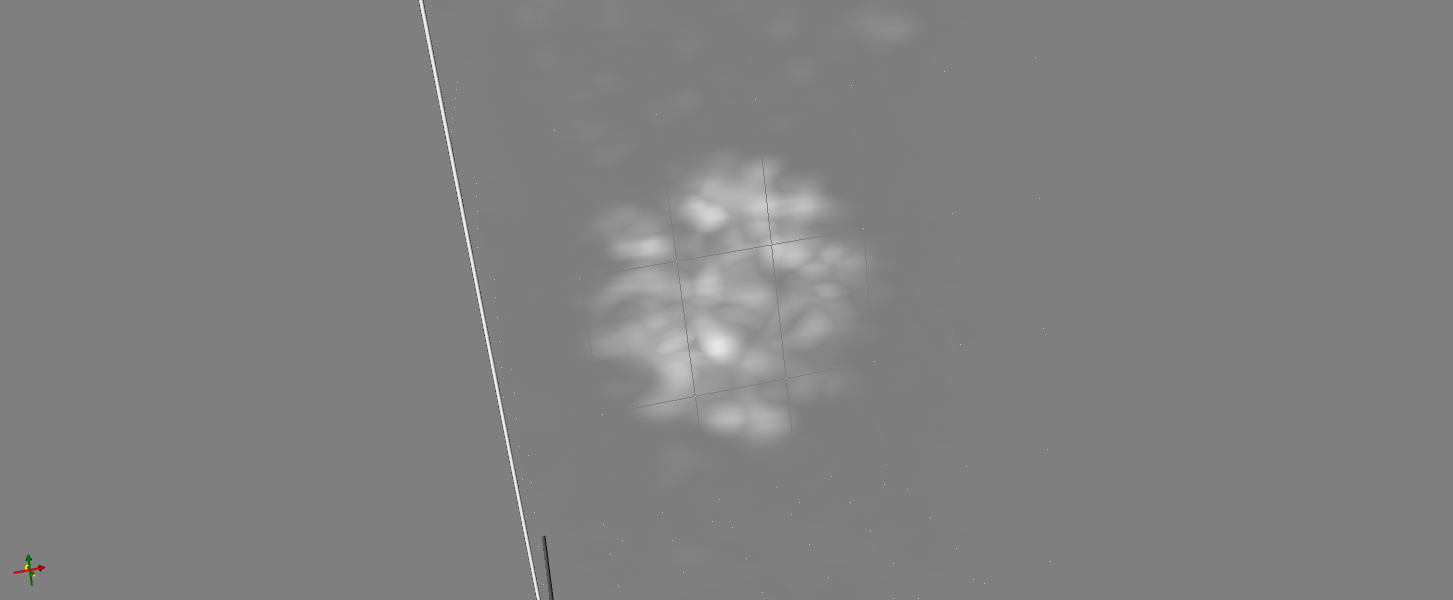

<IPython.core.display.Javascript object>

In [89]:
view_volume_3d(cyst)

#### Profiling

### Beamformer: Compute Delays "On the Fly" (OTF) approach

#### Implementation details

#### Testing

#### Profiling

### Beamformer: further optimization using CUDA Texture memory 

#### Implementation details

#### Testing

#### Profiling

## References

[Jensen2022] Jensen, Jørgen Arendt, et al. , Anatomic and Functional Imaging using Row-Column Arrays. IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control (2022) https://doi.org/10.1109/TUFFC.2022.3191391

[Flesch2017] Flesch, M., et al. "4D in vivo ultrafast ultrasound imaging using a row-column addressed matrix and coherently-compounded orthogonal plane waves." Physics in Medicine & Biology 62.11 (2017): 4571. https://iopscience.iop.org/article/10.1088/1361-6560/aa63d9/meta